# Building a Text Classifier with PyTorch: A Deep Dive into AG News Dataset

Hey everyone! I'm excited to share my journey into the fascinating world of text classification. As someone relatively new to deep learning, I recently embarked on a project to build a model that can categorize news articles. This blog post documents my exploration, using PyTorch and the popular AG News dataset. I'll be walking you through my process, from the initial setup and data wrangling to building the model and evaluating its performance. This is as much a learning experience for me as it is for you, so I'll be sharing my thought process, the challenges I encountered, and the little victories along the way!

My goal is to not just build a functional classifier, but to truly understand *why* each piece of the puzzle works. If you're also diving into deep learning or simply curious about how text can be understood by machines, then join me as I unpack this project step by step. We'll cover the essential concepts of text classification, explore the power of neural networks, and learn how to build a practical model from scratch. Let's see how far we can go!

## What is Text Classification (and Why Should I Care)?

Text classification is basically the act of teaching a computer to automatically organize and sort through written text into different groups or categories. At first, I was kind of blown away by this idea – that machines can actually "understand" the meaning behind words!

Think about all the ways this could be useful: categorizing customer reviews (positive or negative), filtering out spam emails, or like we're doing here – automatically labeling news articles by topic. Understanding how this works is a critical step to applying deep learning to text data. The model we will build will categorize news articles into the following four categories: World, Sports, Business, and Sci/Tech.


### Why AG News Dataset?

The AG News dataset was chosen because it's often used as a starting point for text classification. Its size and clear categories make it a nice balance between being complex enough to learn from and simple enough to not get lost in the details. For a beginner like me, this is the perfect playground to experiment with and start developing an intuition for this whole text classification thing. It also is readily available from the HuggingFace Dataset library, making it super accessible.

<iframe
  src="https://huggingface.co/datasets/wangrongsheng/ag_news/embed/viewer/default/train"
  frameborder="0"
  width="100%"
  height="560px"
></iframe>

## Setting up the Environment

We'll be working with several essential libraries:

-   **PyTorch:** A deep learning framework for building and training neural networks.
-   **Datasets:** The Hugging Face `datasets` library for easy access to datasets.
-   **Torchmetrics:** A library for evaluating models (accuracy)
-   **Collections:** Used to implement counter for tokenization
-   **Re**: used for regex operations for tokenizing

In [144]:
import torch
from torch import nn
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
import re

The initial step involves ensuring GPU availability. This code block leverages PyTorch to check and utilize the GPU for faster computation if it's available.

In [145]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Will be using:", device)

Will be using: cuda


We then download the dataset using the datasets library and extract class names. This will help in knowing the number of labels needed for the classification problem.

In [146]:
ag_news_dataset = load_dataset('wangrongsheng/ag_news')
classes = ag_news_dataset['train'].features['label'].names
classes

['World', 'Sports', 'Business', 'Sci/Tech']

## Preprocessing the Text Data
Preprocessing is a critical step. Text data is raw and must be prepared for the model to ingest. Here's how we approach it:


### Simple Tokenization
We begin by defining a basic tokenizer function:

In [147]:
# Simple tokenizer function
def simple_tokenizer(text):
    # Convert to lowercase and split on whitespace and punctuation
    return re.findall(r'\w+', text.lower())

This function converts text to lowercase and splits it based on whitespace and punctuation using regular expressions. This creates basic token, or words that the model can use.

### Vocabulary Building

The next crucial part is to build a vocabulary to map each word in the dataset to a unique index. This helps convert text to sequences of numbers.

In [148]:
# Modified vocabulary building function
def build_vocabulary(dataset, max_size=40000):
    word_counts = Counter()
    # Special tokens
    special_tokens = ['<PAD>', '<UNK>']
    
    # Count all words
    print("Building vocabulary...")
    for item in dataset:
        tokens = simple_tokenizer(item['text'])
        word_counts.update(tokens)
    
    # Get most common words
    most_common = [word for word, _ in word_counts.most_common(max_size - len(special_tokens))]
    vocab = special_tokens + most_common
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    
    return word2idx, len(word2idx)

word2idx, VOCAB_SIZE = build_vocabulary(ag_news_dataset['train'])
print(f"Vocabulary size: {VOCAB_SIZE}")

Building vocabulary...
Vocabulary size: 40000


This function counts word frequencies, takes the most frequent words, and creates a mapping. Special <PAD> (padding) and <UNK> (unknown) tokens are also added. We use these special tokens for handling sequence variability when training the model.

### Creating DataLoaders

The collate_fn function is a function that processes data and prepares it in a way the model can accept.

In [149]:

# Modified collate function
def collate_fn(batch, max_length=128):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])
    
    # Tokenize and convert to indices
    sequences = []
    for text in texts:
        tokens = simple_tokenizer(text)[:max_length]
        # Use the PAD and UNK tokens we defined
        indices = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
        padding = [word2idx['<PAD>']] * (max_length - len(indices))
        indices.extend(padding)
        sequences.append(indices[:max_length])
    
    return torch.tensor(sequences), labels

This function converts tokenized texts to sequences of indices, performs padding to ensure consistent sequence length.

For training the model, we need to feed the data in batches. The following creates dataloaders for both training and test data.

In [150]:
BATCH_SIZE = 128
train_dataloader = DataLoader(ag_news_dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(ag_news_dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn)
next(iter(train_dataloader))

(tensor([[ 3058,   621,    98,  ...,     0,     0,     0],
         [  752,  2530,   154,  ...,     0,     0,     0],
         [ 1428,   662,   685,  ...,     0,     0,     0],
         ...,
         [10564,   115,  2316,  ...,     0,     0,     0],
         [   40,   116,     5,  ...,     0,     0,     0],
         [17210,  2379,     3,  ...,     0,     0,     0]]),
 tensor([1, 0, 0, 0, 2, 0, 3, 1, 2, 3, 1, 0, 1, 0, 2, 0, 1, 3, 3, 1, 3, 0, 0, 3,
         0, 2, 3, 2, 2, 0, 3, 1, 2, 1, 0, 1, 1, 0, 3, 2, 1, 2, 3, 3, 2, 2, 0, 1,
         3, 2, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 1, 0, 1, 3, 0, 1, 3, 1, 3,
         1, 3, 1, 0, 2, 3, 2, 0, 2, 2, 1, 1, 3, 1, 2, 3, 3, 1, 2, 3, 2, 1, 0, 1,
         0, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 1, 2, 3, 1, 2, 0, 0, 0, 1, 1,
         3, 3, 1, 2, 3, 1, 1, 2]))

## Model Architecture

The model, called AgNewsModal, employs a neural network with these features:

* Embedding Layer: Converts input tokens to dense vector embeddings.

* LSTM Layer: A recurrent neural network that processes sequences of data. We use a bidirectional LSTM to understand the information from both directions of the text.

* Linear Layers: We added a layer that includes a BatchNorm1d layer, ReLU activation, and a dropout layer.

* Classifier Layer: A final linear layer that maps the processed features to the output classes.

In [151]:
class AgNewsModal(nn.Module):
    """
    AgNewsModal is a neural network model designed for text classification tasks, specifically for the AG News dataset.
    Args:
        num_emb (int): The size of the vocabulary (number of unique tokens).
        output_size (int): The number of output classes.
        num_layers (int, optional): The number of LSTM layers. Default is 2.
        hidden_size (int, optional): The number of features in the hidden state of the LSTM. Default is 128.
        dropout_rate (float, optional): The dropout rate to be applied in the LSTM and fully connected layers. Default is 0.3.
    Attributes:
        embedding (nn.Embedding): Embedding layer that converts input tokens to dense vectors.
        lstm (nn.LSTM): LSTM layer for sequential processing of the embedded tokens.
        layers (nn.Sequential): A sequence of layers including Linear, BatchNorm1d, ReLU, and Dropout for further processing.
        classifier (nn.Linear): Linear layer that maps the processed features to the output classes.
    Methods:
        forward(x):
            Defines the forward pass of the model.
            Args:
                x (torch.Tensor): Input tensor of shape [batch, seq_len].
            Returns:
                torch.Tensor: Output tensor of shape [batch, output_size] containing the class scores.
    """
    def __init__(self,num_emb, output_size, num_layers=2, hidden_size=128, dropout_rate=0.3):
        super().__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Add LSTM for sequential processing
        self.lstm = nn.LSTM(
            hidden_size, 
            hidden_size//2, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=True,
            dropout=dropout_rate
        )
        
        self.layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.BatchNorm1d(hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.classifier = nn.Linear(hidden_size//2, output_size)
    
    def forward(self, x):
        x = self.embedding(x)          # [batch, seq_len, hidden_size]
        x, _ = self.lstm(x)           # [batch, seq_len, hidden_size]
        x = x.mean(dim=1)             # [batch, hidden_size]
        x = self.layers(x)            # [batch, hidden_size//2]
        x = self.classifier(x)        # [batch, output_size]
        return x
    
model_0 = AgNewsModal(len(word2idx), len(classes))
model_0

AgNewsModal(
  (embedding): Embedding(40000, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (classifier): Linear(in_features=64, out_features=4, bias=True)
)

The forward pass sends the data through the layers mentioned.

## Training and Evaluation
With the model architecture in place, we will now discuss about how we are going to train and evaluate the model.

### Training Setup
The training phase is set up using these important components.

In [152]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.02)

We set up an accuracy metric, loss function, and the optimizer used for training.

### Training and Test Step

The next part is writing the function that will be used for training and testing.

In [153]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

These function will train and test the data using the model and will return results based on the data.

### Model Evaluation
The last piece is evaluating the model using the test set.

This function calculates and prints metrics for model performance.

In [154]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {
            "model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()
        }

### Running Training
This section of code loops through the number of epochs and calls the function for training and testing.

In [155]:

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn
    )

Epoch: 0
---------
Looked at 0/120000 samples
Looked at 51200/120000 samples
Looked at 102400/120000 samples
Train loss: 0.34499 | Train accuracy: 0.88%
Test loss: 0.29629 | Test accuracy: 0.91%

Epoch: 1
---------
Looked at 0/120000 samples
Looked at 51200/120000 samples
Looked at 102400/120000 samples
Train loss: 0.23752 | Train accuracy: 0.92%
Test loss: 0.27870 | Test accuracy: 0.91%

Epoch: 2
---------
Looked at 0/120000 samples
Looked at 51200/120000 samples
Looked at 102400/120000 samples
Train loss: 0.23524 | Train accuracy: 0.92%
Test loss: 0.33398 | Test accuracy: 0.89%



## Results and Conclusion
The training resulted in these results:

In [156]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=acc_fn
)
model_0_results

{'model_name': 'AgNewsModal',
 'model_loss': 0.33398252725601196,
 'model_acc': 0.8918403387069702}

The model achieved an above accuracy, indicating effective learning from the dataset. We also visualize the performance of the model using the confusion matrix to better understand how the model performs.

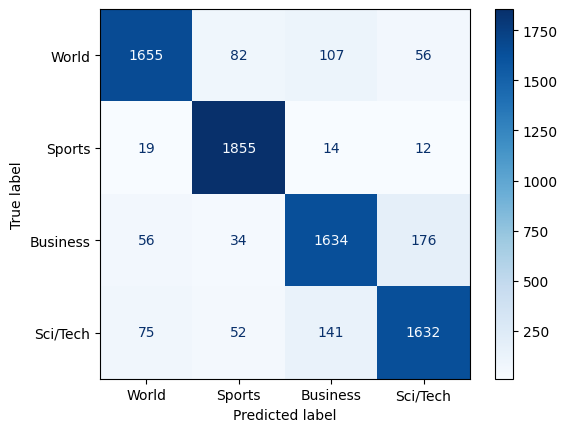

In [157]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Get predictions and true labels
all_preds = []
all_labels = []

model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_0(X)
        all_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Conflusion